scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.1 scipy==1.10.1 pandas==1.4.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8
... reading from cache file cache/raw_data-16434_filtered_feature_bc_matrix-matrix.h5ad
 
Number of cells: 3368
Number of genes: 19176
 
normalizing counts per cell
    finished (0:00:00)


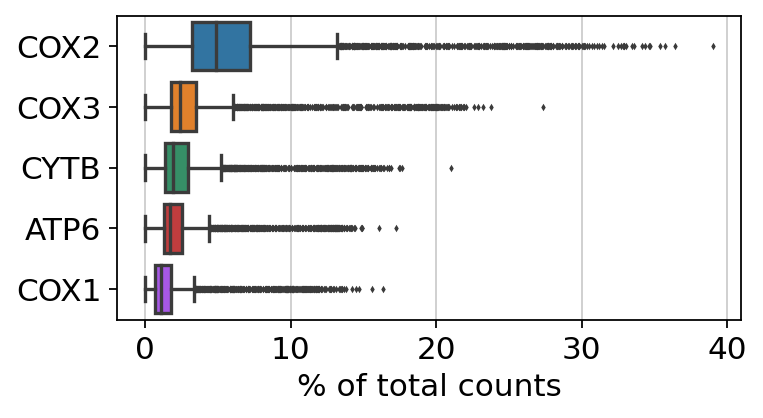

Top 5 highest expression genes


In [1]:
# Question: 1 to 3

# Type in the following commands in the Terminal
# wget -O GSE156755_RAW.tar.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE156755&format=file'
# mkdir raw_data
# tar -zxf GSE156755_RAW.tar.gz --directory raw_data
# cd raw_data
# tar -zxf GSM4743527_16434_filtered_feature_bc_matrix.tar.gz

# Importing packages
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import scanorama

sc.set_figure_params(dpi=80, color_map='viridis')
sc.settings.verbosity = 2
sc.logging.print_header()

geo_data = sc.read_10x_mtx('raw_data/16434_filtered_feature_bc_matrix/', var_names = 'gene_symbols', cache = True)
geo_data.var_names_make_unique()

#####################################################################################################################

# Question: 4 and 5 - Before Pre-processing
num_cells = geo_data.n_obs
num_genes = geo_data.n_vars

# print the results
print(' ')
print('Number of cells:', num_cells)
print('Number of genes:', num_genes)
print(' ')

# Top 5 highest expression genes
sc.pl.highest_expr_genes(geo_data, n_top = 5)
print('Top 5 highest expression genes')

Violin Plots Before Processing


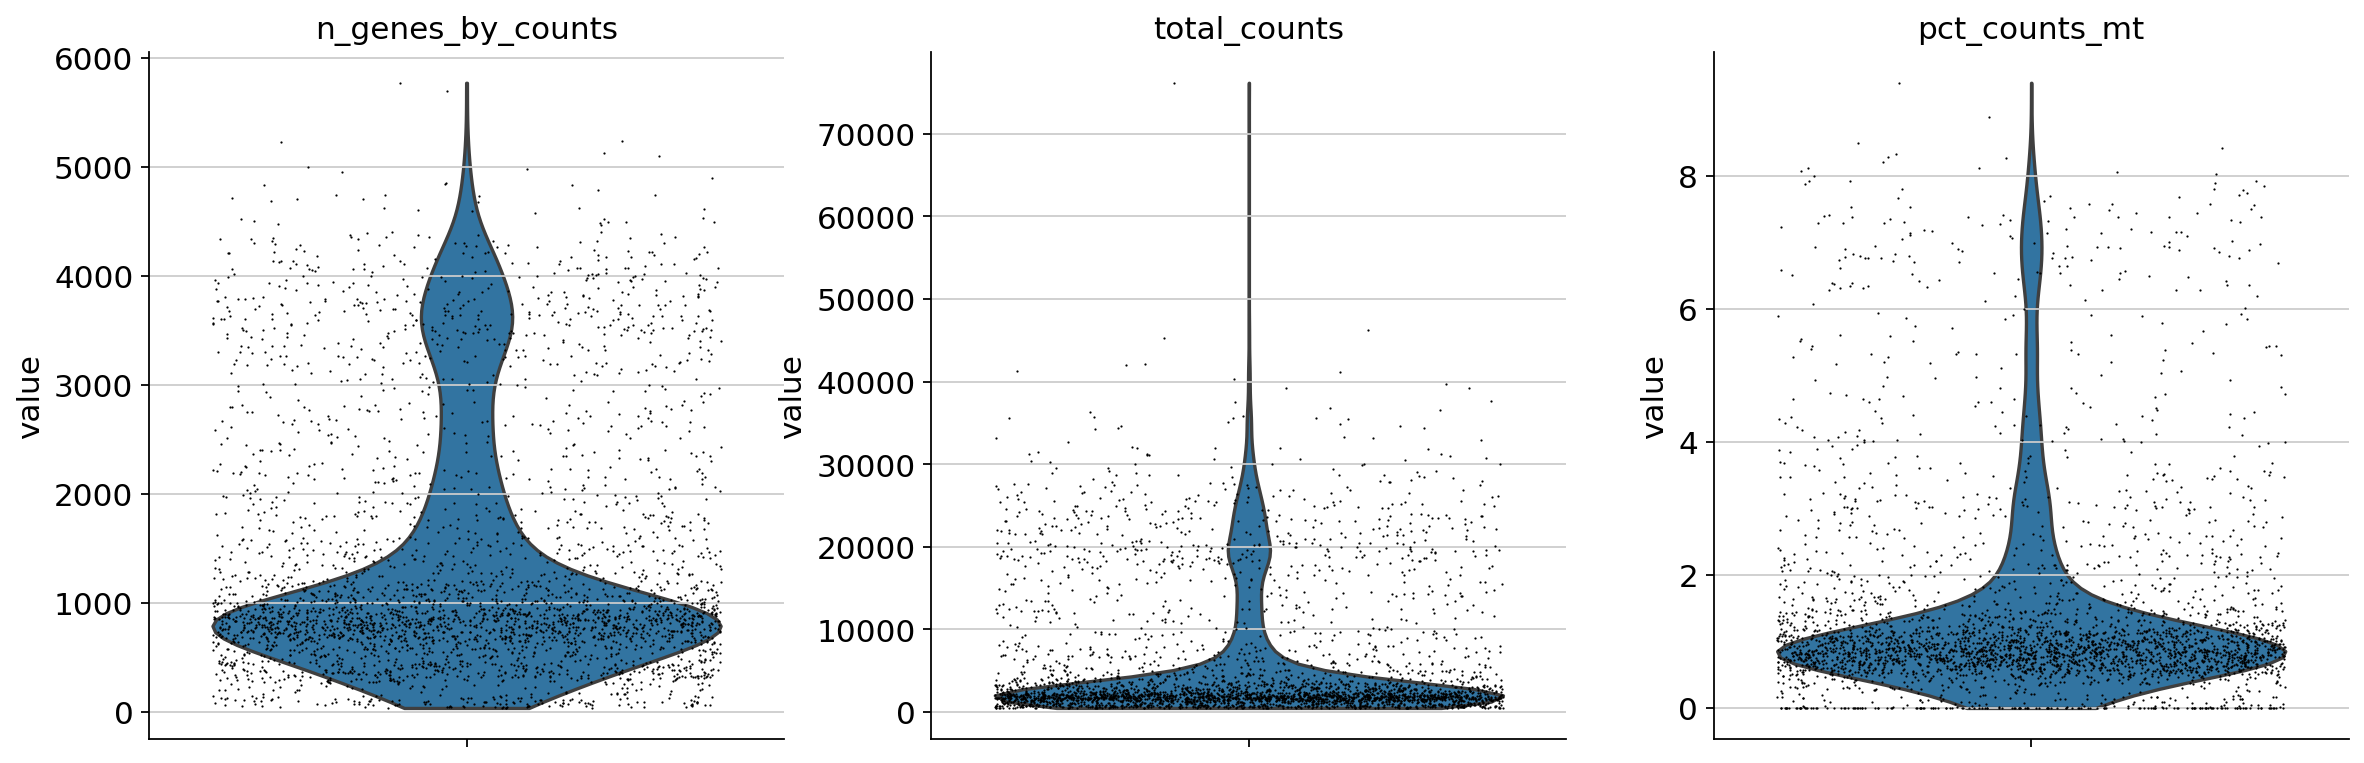

Scatter Plots Before Processing


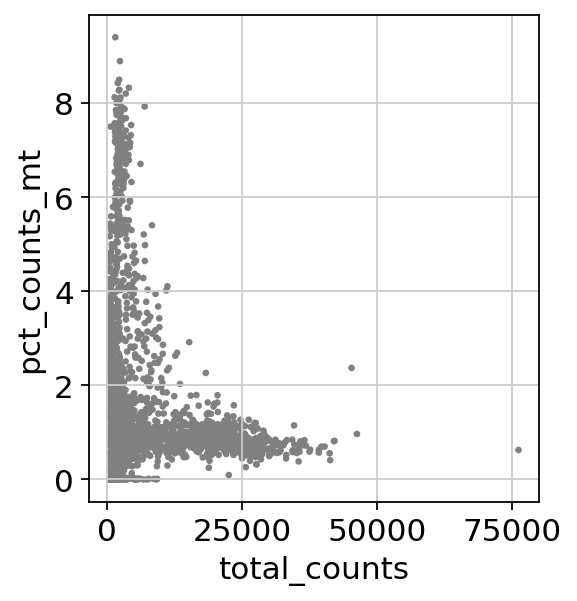

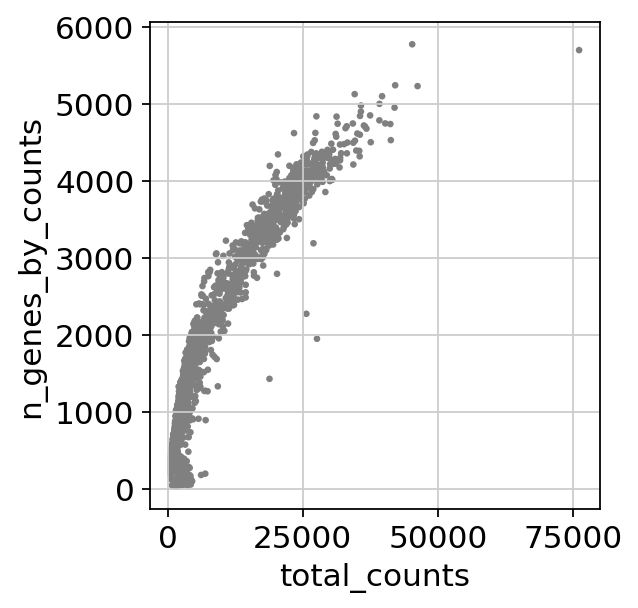

 
We filter cells that have unique feature counts over 5500 or less than 200 or > 5% mitochondrial counts (Thresholds determined from the above distribution)
Reason:
1) Low-quality cells or empty droplets will often have very few genes
2) Cell doublets or multiplets may exhibit an aberrantly high gene count
3) Leaking cells (which are either dead or low-quality) often exhibit extensive mitochondrial contamination
 
filtered out 165 cells that have less than 200 genes expressed
filtered out 5348 genes that are detected in less than 3 cells
 
Violin Plots After Processing


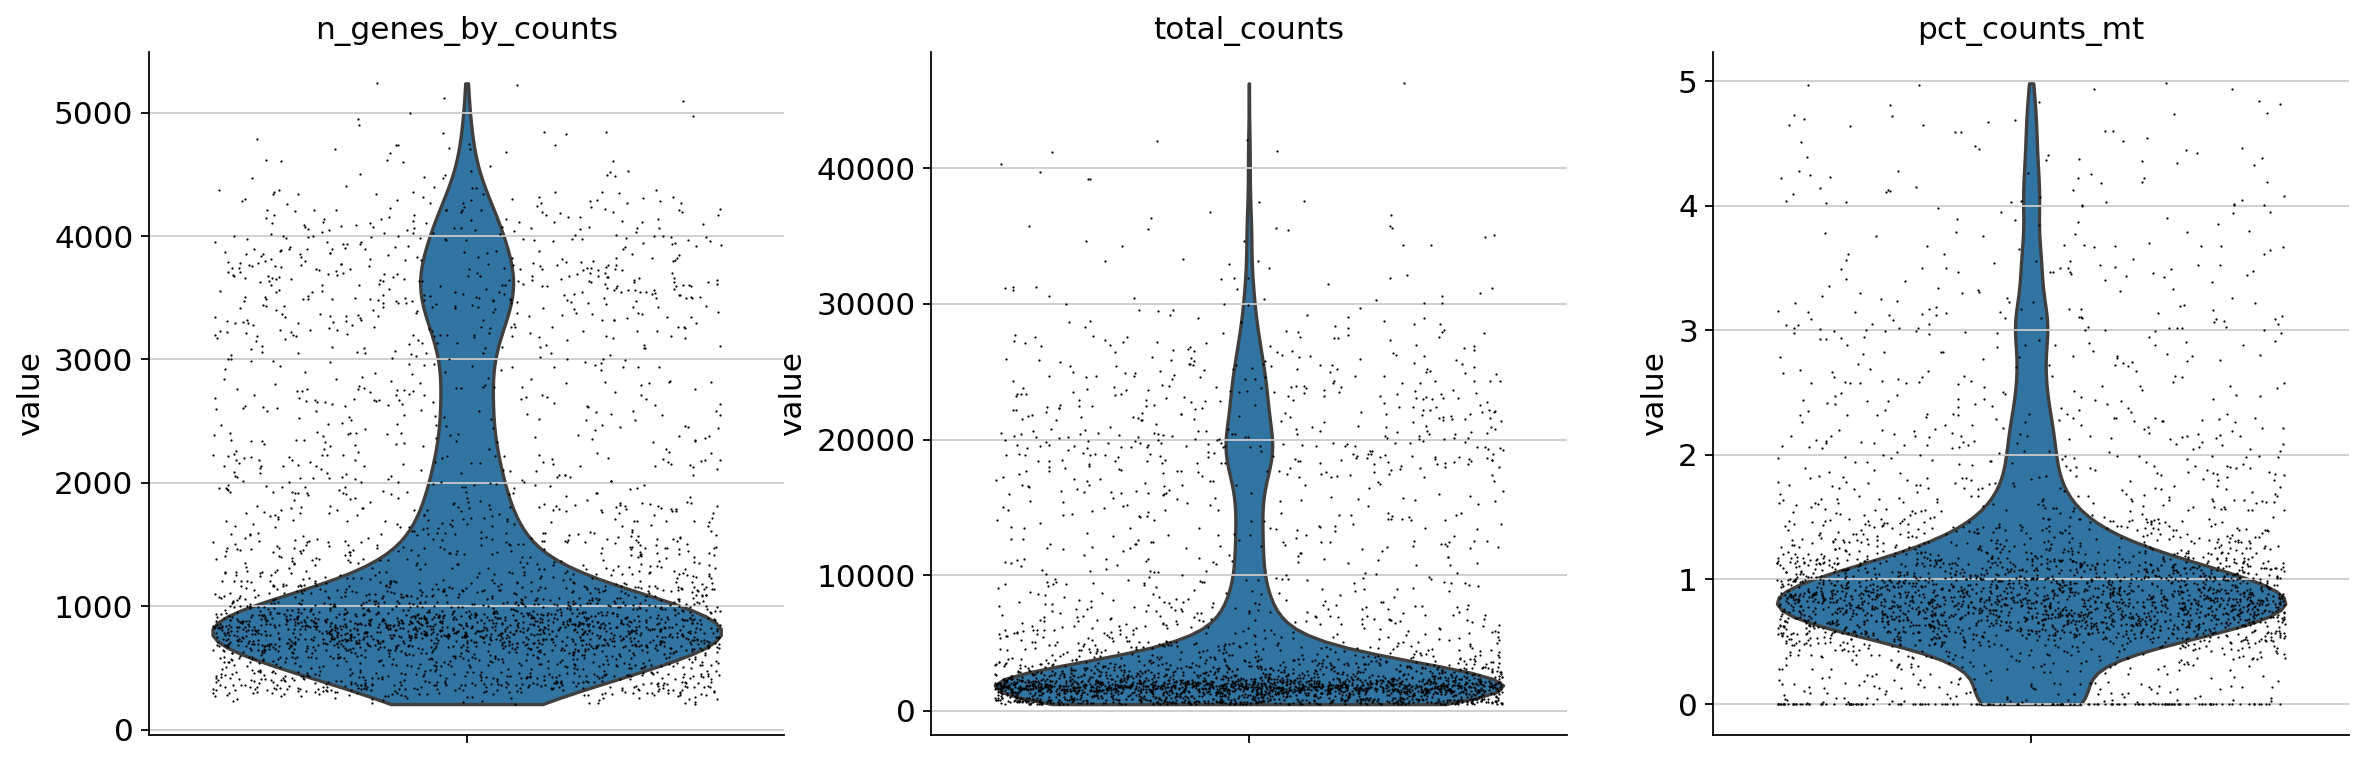

Scatter Plots After Processing


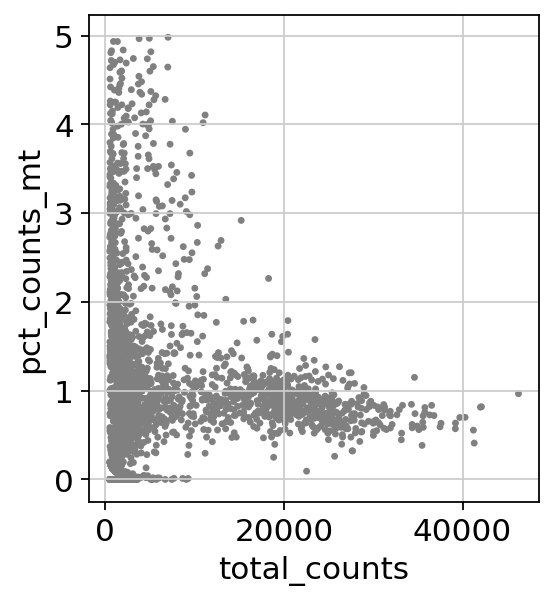

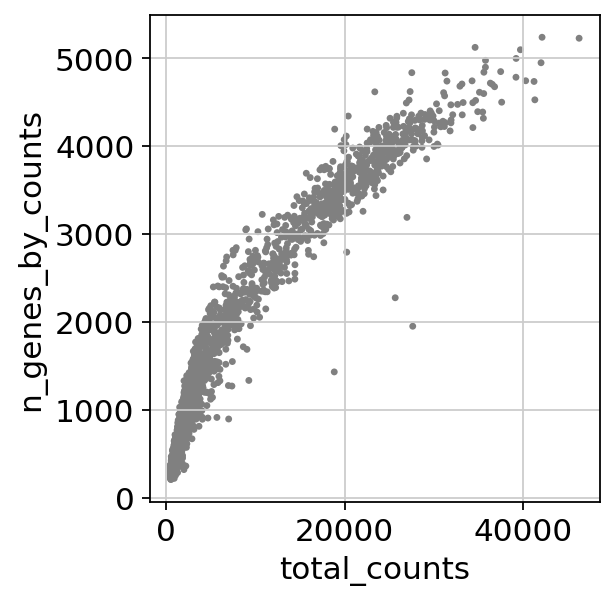

normalizing counts per cell
    finished (0:00:00)


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [2]:
# Pre-processing - Based on QC metrics from this article - https://doi.org/10.1186%2Fs13059-016-0888-1

geo_data.var['mt'] = geo_data.var_names.str.startswith('MT-') # mitochondrial genes
sc.pp.calculate_qc_metrics(geo_data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Visualize QC metrics to see the distribution to determine thresholds
print('Violin Plots Before Processing')
sc.pl.violin(geo_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# Visualize feature-feature relationships
print('Scatter Plots Before Processing')
sc.pl.scatter(geo_data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(geo_data, x='total_counts', y='n_genes_by_counts')

# Filter out low-quality cells and genes
print(' ')
print('We filter cells that have unique feature counts over 5500 or less than 200 or > 5% mitochondrial counts (Thresholds determined from the above distribution)')  
print('Reason:')
print('1) Low-quality cells or empty droplets will often have very few genes')
print('2) Cell doublets or multiplets may exhibit an aberrantly high gene count')
print('3) Leaking cells (which are either dead or low-quality) often exhibit extensive mitochondrial contamination')
print(' ')

sc.pp.filter_cells(geo_data, min_genes = 200)
sc.pp.filter_genes(geo_data, min_cells = 3)
geo_data = geo_data[geo_data.obs.n_genes_by_counts < 5500, :]
geo_data = geo_data[geo_data.obs.pct_counts_mt < 5, :]

# Visualize QC metrics again
print(' ')
print('Violin Plots After Processing')
sc.pl.violin(geo_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
print('Scatter Plots After Processing')
sc.pl.scatter(geo_data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(geo_data, x='total_counts', y='n_genes_by_counts')

# Normalizing the data

sc.pp.normalize_total(geo_data, target_sum = 1e4)
sc.pp.log1p(geo_data)

Number of cells after pre-processing: 3144
Number of genes after pre-processing: 13828
 
normalizing counts per cell
    finished (0:00:00)


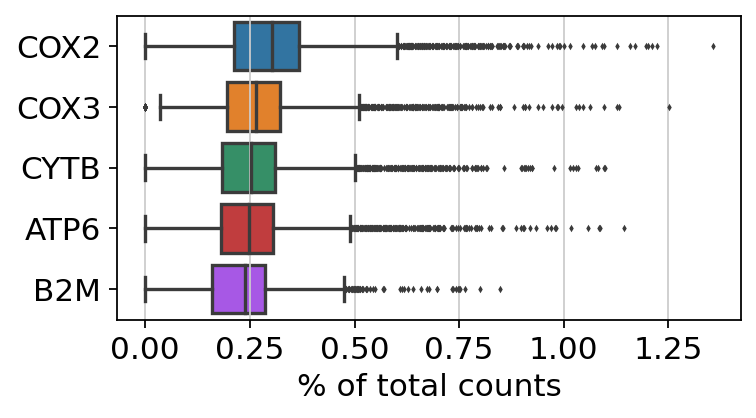

In [3]:
# Question: 4 and 5 - After Pre-processing

# After pre-processing, the number of cells and genes
num_cells = geo_data.n_obs
num_genes = geo_data.n_vars

# print the results
print("Number of cells after pre-processing:", num_cells)
print("Number of genes after pre-processing:", num_genes)
print(' ')

# Top 5 highest expression genes
sc.pl.highest_expr_genes(geo_data, n_top = 5)

extracting highly variable genes
    finished (0:00:00)


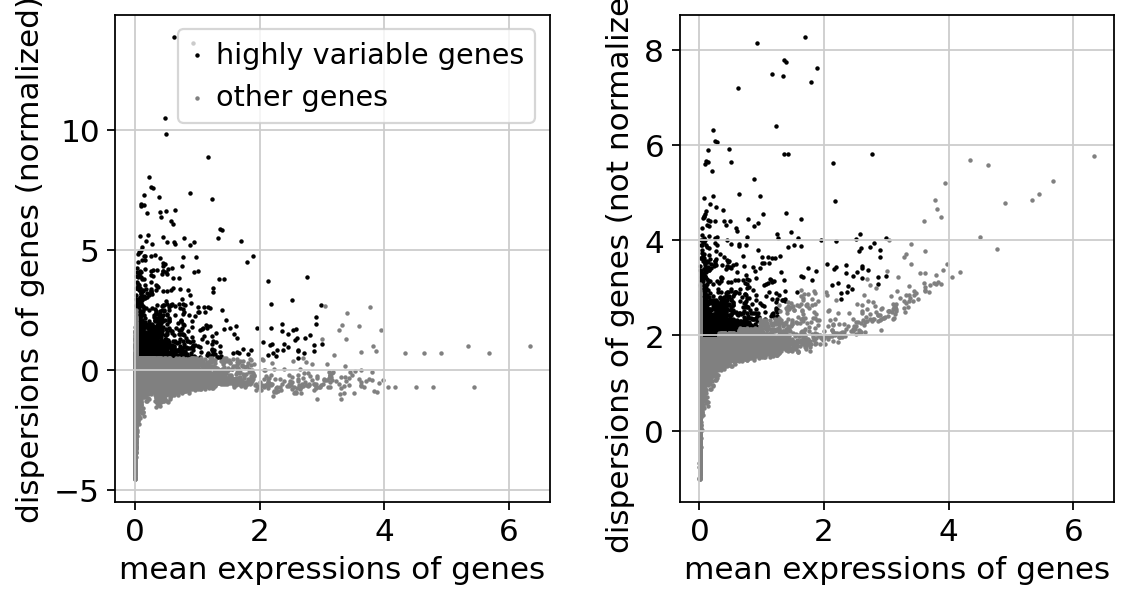

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:01)


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


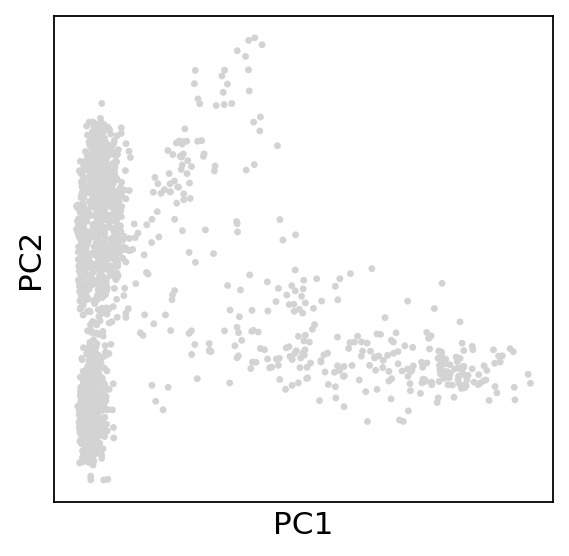

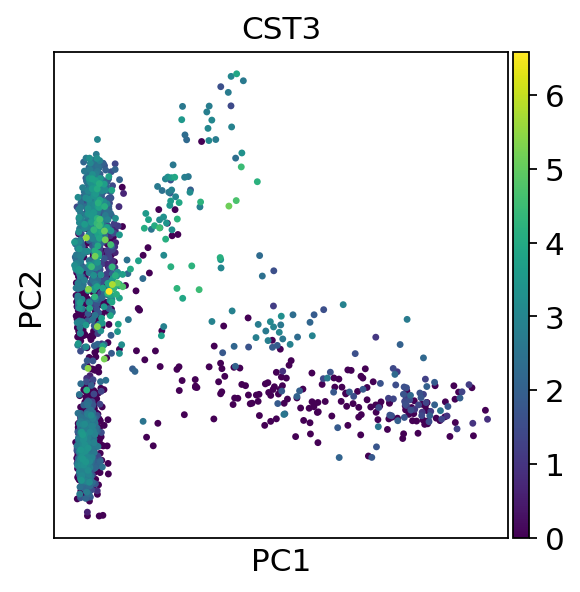

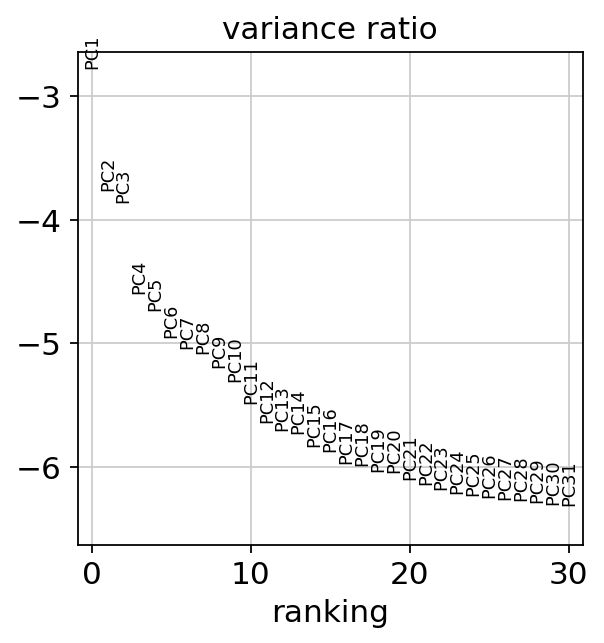

In [4]:
# Question: 6 - Dimensionality Reduction 

# Identification of highly variable features 

geo_data.raw = geo_data

sc.pp.highly_variable_genes(geo_data) # Default settings
sc.pl.highly_variable_genes(geo_data)
geo_data = geo_data[:, geo_data.var.highly_variable]

# As a personal choice, I prefer not to regress out the fraction of mitochondrial reads and the number of detected genes 
# (Reference: https://github.com/scverse/scanpy/issues/526)

# Scaling each gene to unit variance
sc.pp.scale(geo_data, max_value=10)

# PCA
sc.tl.pca(geo_data, svd_solver = 'arpack', use_highly_variable = True)
sc.pl.pca(geo_data) 
sc.pl.pca(geo_data, color='CST3') # By gene expression - CST3 can be substituted with any other gene
sc.pl.pca_variance_ratio(geo_data, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:04)


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


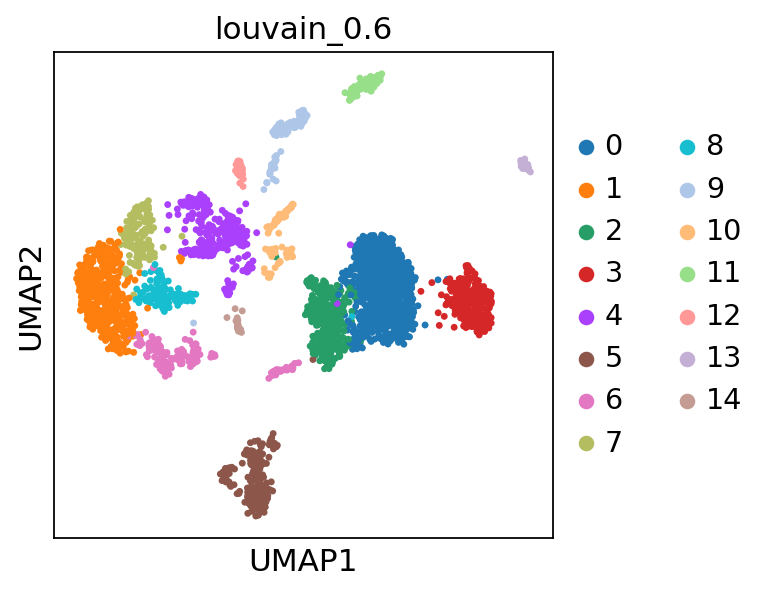

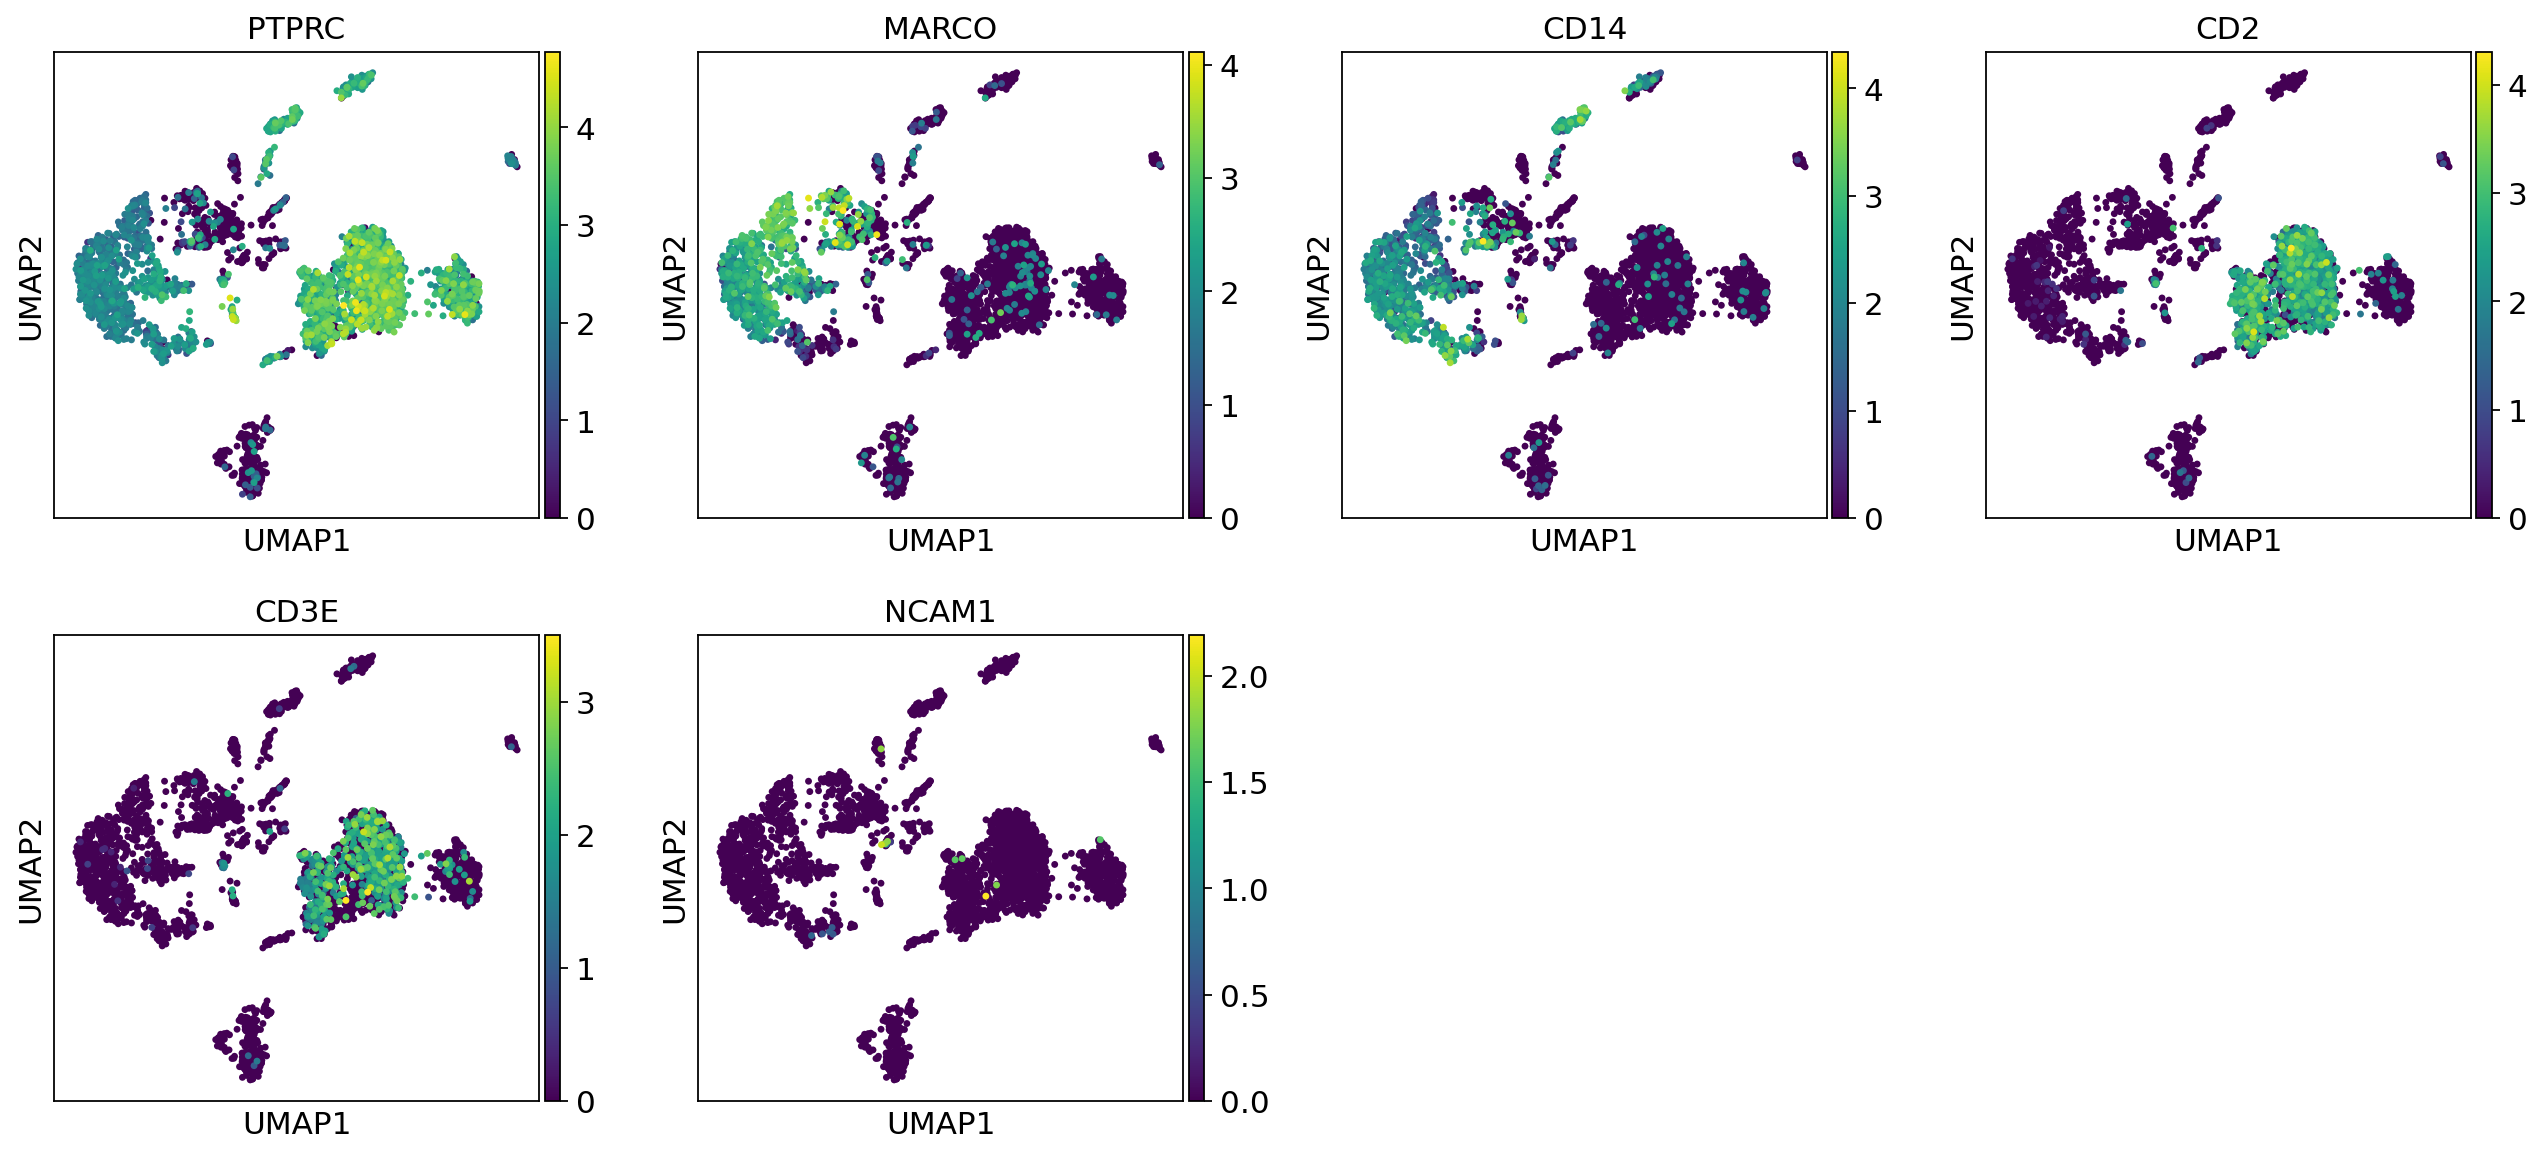

In [5]:
# Question: 7 - Computing the neighborhood graph

sc.pp.neighbors(geo_data)

#############################################################################################################################################

# Question: 8 - UMAP embedding

sc.tl.louvain(geo_data,resolution = 0.6, random_state = 42, key_added = "louvain_0.6") # For the clustering algroithm, I used Louvain clustering

sc.tl.paga(geo_data, groups = "louvain_0.6")
sc.pl.paga(geo_data, plot=False)  
sc.tl.umap(geo_data, init_pos='paga')
sc.pl.umap(geo_data, color='louvain_0.6')

#############################################################################################################################################

# Question: 9 - Embedding coloured by the genes
sc.pl.umap(geo_data, color=['PTPRC', 'MARCO', 'CD14', 'CD2', 'CD3E', 'NCAM1']) # Note: CD56 is also referred to as NCAM1

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:03)


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


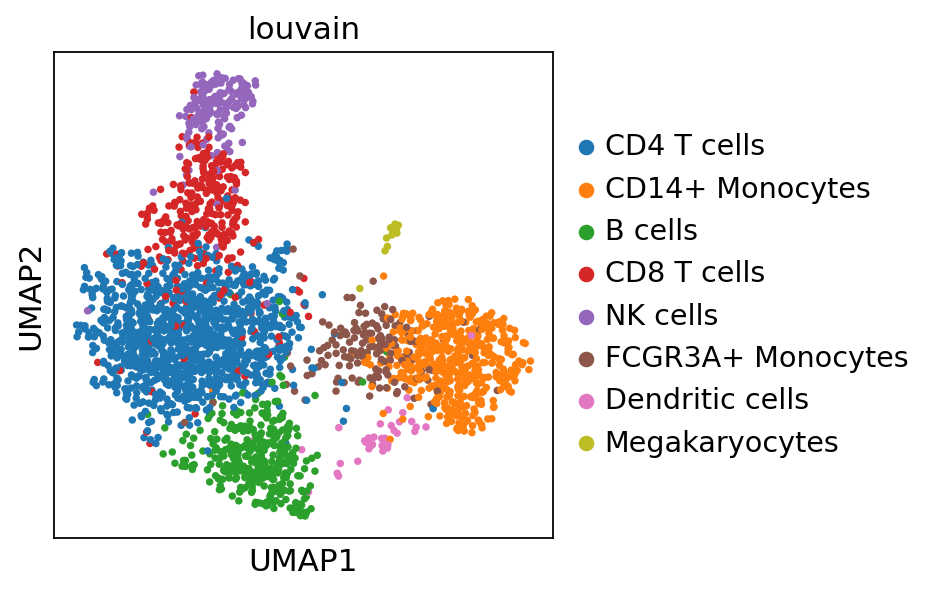

In [6]:
# Question 10: Celltype Prediction

# Note: 
# Rather than using a reference marker genes to identify cell identity, I used an annotated reference dataset for identifying the cell types
# This method involves using a reference PBMC dataset (from from 10x Genomics), integrating them using scanorama package and doing label transfer based on closest neighbors
# For reference: https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html

# Loaded the reference data - It is the annotated and processed pbmc3k dataset from 10x
adata_ref = sc.datasets.pbmc3k_processed() 

# To compare the datasets, they need to be defined on the same variables
var_names = adata_ref.var_names.intersection(geo_data.var_names)
adata_ref = adata_ref[:, var_names]
geo_data = geo_data[:, var_names]

# UMAP of the reference data
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color='louvain')

Found 236 genes among all datasets
[[0.         0.89234268]
 [0.         0.        ]]
Processing datasets (0, 1)
computing neighbors


/home/madhesh/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


    finished (0:00:00)
computing UMAP
    finished (0:00:07)


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


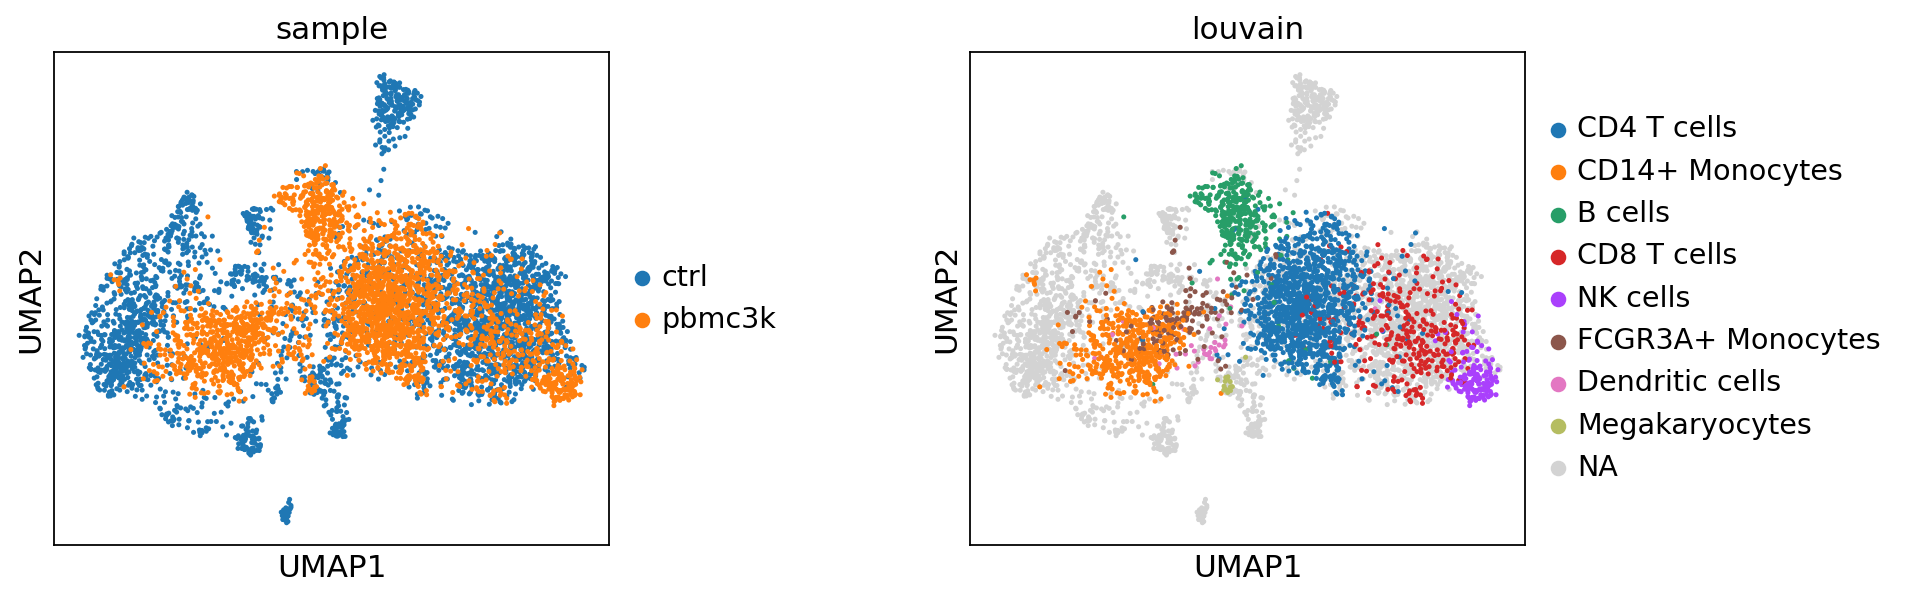

In [7]:
# Question: 10 - Contd.

# Using scanorama to integrate datasets

#subset the individual dataset to the same variable genes as in MNN-correct
alldata = dict()
alldata['ctrl'] = geo_data
alldata['ref'] = adata_ref

adatas = list(alldata.values()) #convert to list of AnnData objects
scanorama.integrate_scanpy(adatas, dimred = 50) # run scanorama integrate function
adata_ref.obs['sample'] = 'pbmc3k' # add in sample info

# create a merged scanpy object and add in the scanorama 
adata_merged = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample', batch_categories=['ctrl','pbmc3k'])
embedding = np.concatenate([ad.obsm['X_scanorama'] for ad in adatas], axis=0)
adata_merged.obsm['Scanorama'] = embedding

#run UMAP
sc.pp.neighbors(adata_merged, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color=["sample","louvain"], wspace = 0.5)

/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


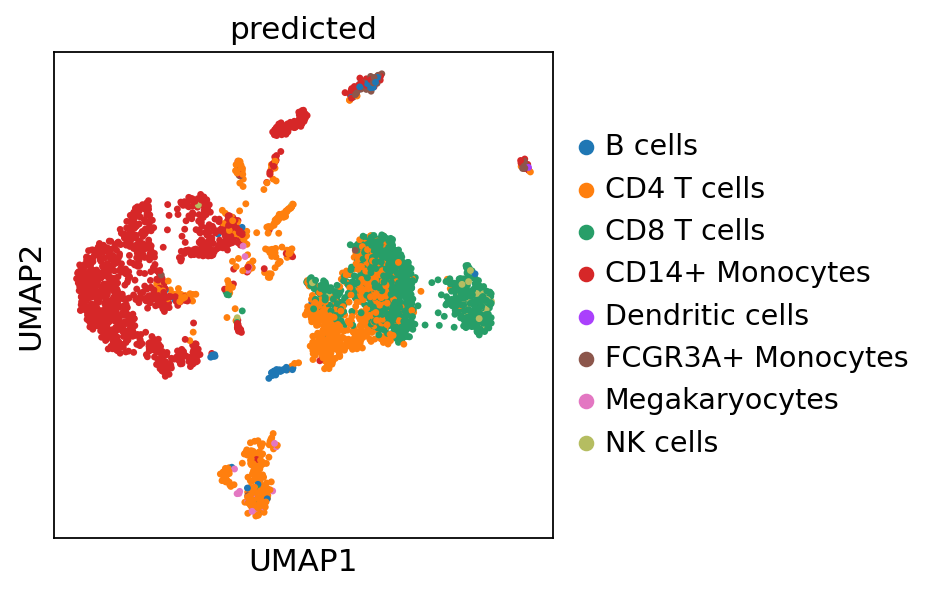

In [8]:
# Question: 10 - Contd.

# Label transfer from the reference dataset to the control dataset
from sklearn.metrics.pairwise import cosine_distances

# Calculating cosine distances 
distances = 1 - cosine_distances(
    adata_merged[adata_merged.obs['sample'] == "pbmc3k"].obsm["Scanorama"],
    adata_merged[adata_merged.obs['sample'] == "ctrl"].obsm["Scanorama"],
)

def label_transfer(dist, labels, index):
    lab = pd.get_dummies(labels)
    class_prob = lab.to_numpy().T @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    # convert to df
    cp_df = pd.DataFrame(
        class_prob, columns=lab.columns
    )
    cp_df.index = index
    # classify as max score
    m = cp_df.idxmax(axis=1)
    
    return m

class_def = label_transfer(distances, adata_ref.obs.louvain, geo_data.obs.index)

# add to obs section of the original object
geo_data.obs['predicted'] = class_def

# UMAP of predicted labels
sc.pl.umap(geo_data, color="predicted")

/tmp/ipykernel_32467/2677203401.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adata_merged.obs['predicted'] = class_def.append(adata_ref.obs['louvain']).tolist() # add to merged object
/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


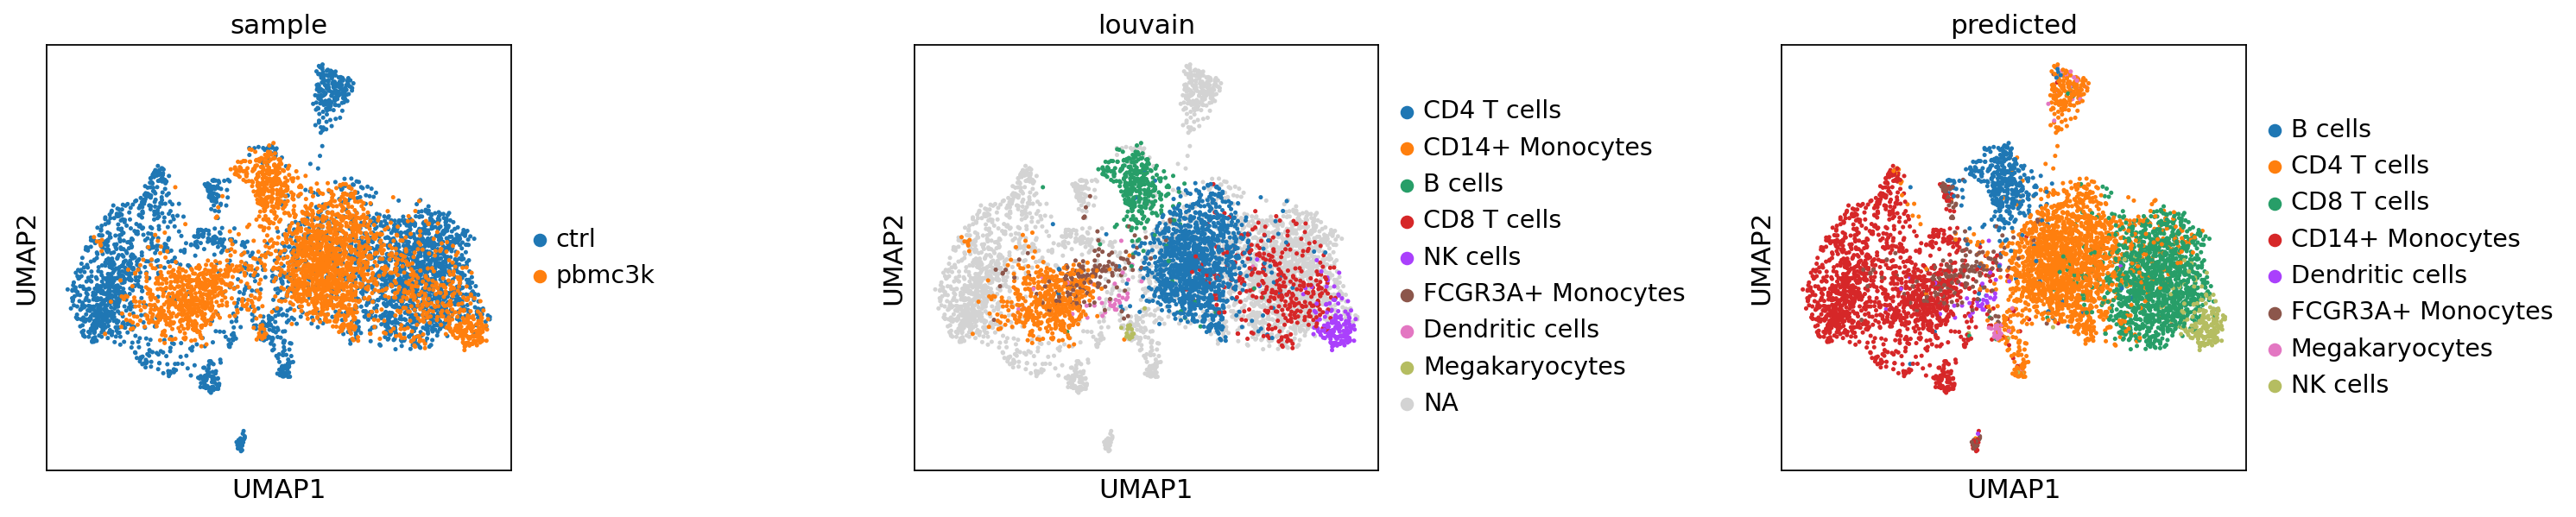

/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


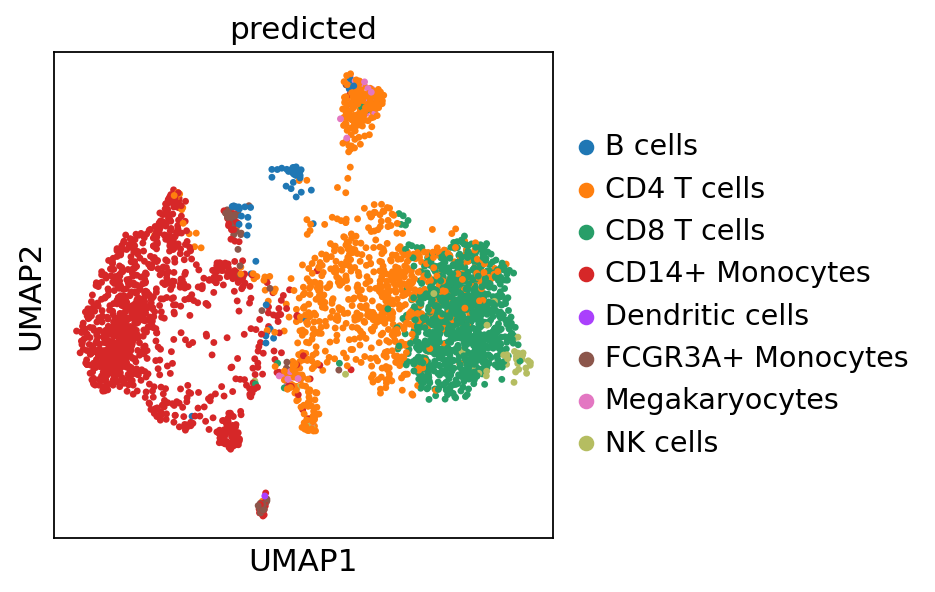

UMAP projection of sample GSM4743527_16434 along with cell type annotation
 
Conclusion: 
From this plot, we can clearly say that the sample predominantly consists of classical monocytes (CD14+ CD16-), helper T cells (CD4+), cytotoxic T cells (CD8+),
B cells, natural killer (NK) cells, and alternatively activated monocytes (CD14- CD16+)
 
 
Note to the answer previous question:
Since the reference dataset does not distingush between naive monocytes and matured macrophages (both clubbed together as CD14+ monocytes),
one cannot surely say whether it is macrophages or monocytes in the cluster.
 
One simple test to see the presence of macrophages in the CD14+ monocyte cluster is to use a macrophage marker gene expression, as shown below:
 


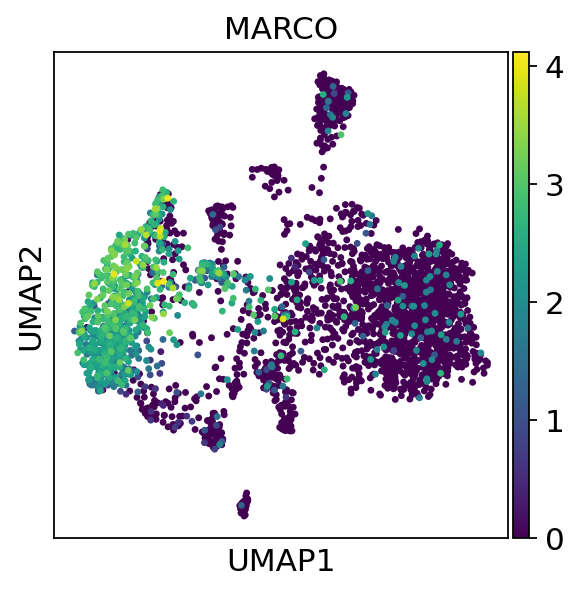

In [9]:
# Question 10: Contd.

adata_merged.obs['predicted'] = class_def.append(adata_ref.obs['louvain']).tolist() # add to merged object

# Plotting all three UMAPS
sc.pl.umap(adata_merged, color=["sample","louvain",'predicted'], wspace = 0.7)

# Final Result - Plot only predicted labels from the original dataset (referred here as ctrl)
print(' ')
sc.pl.umap(adata_merged[adata_merged.obs['sample']=='ctrl'], color='predicted')
print('UMAP projection of sample GSM4743527_16434 along with cell type annotation')
print(' ')
print('Conclusion: ')
print('From this plot, we can clearly say that the sample predominantly consists of classical monocytes (CD14+ CD16-), helper T cells (CD4+), cytotoxic T cells (CD8+),')
print('B cells, natural killer (NK) cells, and alternatively activated monocytes (CD14- CD16+)')
print(' ')

# Note to the answer previous question:
print(' ')
print('Note to the answer previous question:')
print('Since the reference dataset does not distingush between naive monocytes and matured macrophages (both clubbed together as CD14+ monocytes),')
print('one cannot surely say whether it is macrophages or monocytes in the cluster.')
print(' ')
print('One simple test to see the presence of macrophages in the CD14+ monocyte cluster is to use a macrophage marker gene expression, as shown below:')
print(' ')
sc.pl.umap(adata_merged[adata_merged.obs['sample']=='ctrl'], color = 'MARCO')


... reading from cache file cache/raw_data-16434_filtered_feature_bc_matrix-matrix.h5ad
computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:04)


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


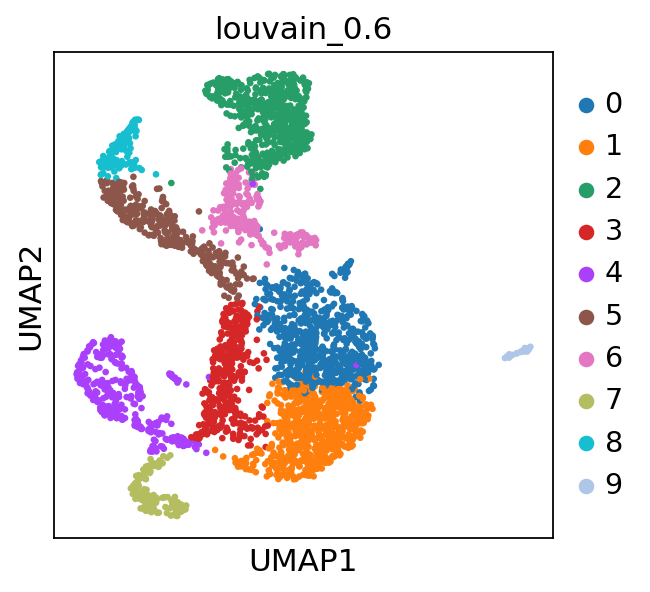

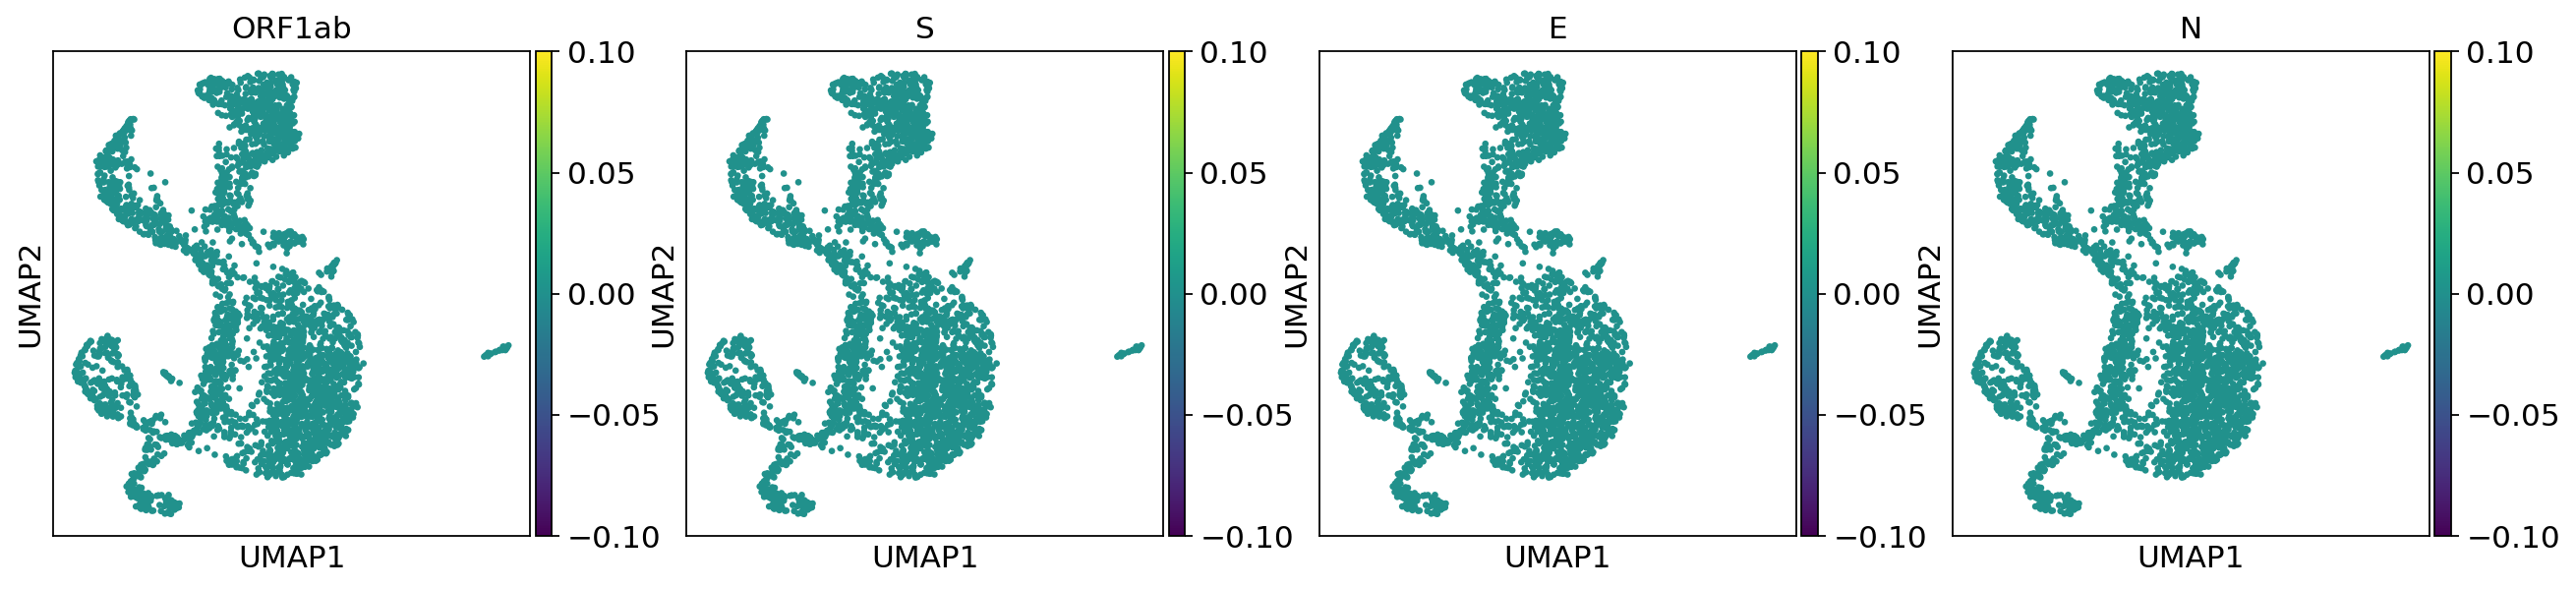

 
From these plots, we can conclude that no cells express the viral gene expression
 


/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:697: RuntimeWarning: invalid value encountered in divide
  frac = (frac - dot_min) / old_range
/home/madhesh/.local/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


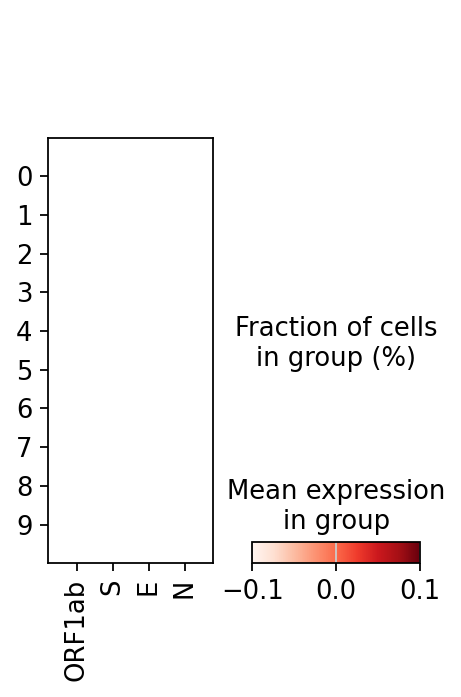

 
To further prove the point, there is no cell fraction in any cluster expressing any viral genes.


In [10]:
# Question: 12 - Are the cells in this sample infected by SARS-CoV-2?

# I came to realise after a while that this was a control sample, implying in theory, there should be no viral transcripts in the cells
# Thus I assumed during the QC, the viral RNA data may be filtered out. 
# So, I am recalling the original raw matrix to see if that's true or not.

# Reading the matrix
geo_data = sc.read_10x_mtx('raw_data/16434_filtered_feature_bc_matrix/', var_names = 'gene_symbols', cache = True)
geo_data.var_names_make_unique()

# PCA, UMAP
sc.tl.pca(geo_data, svd_solver = 'arpack')
sc.pp.neighbors(geo_data)
sc.tl.louvain(geo_data,resolution = 0.6, random_state = 42, key_added = "louvain_0.6") # For the clustering algroithm, I used Louvain clustering
sc.tl.paga(geo_data, groups = "louvain_0.6")
sc.pl.paga(geo_data, plot=False)  
sc.tl.umap(geo_data, init_pos='paga')
sc.pl.umap(geo_data, color='louvain_0.6')

# Plotting the embedding coloured by a few viral genes - ORF1ab, Spike (S), Envelope (E) and Membrane (M)
sc.pl.umap(geo_data, color=['ORF1ab','S','E','N'])
print(' ')
print('From these plots, we can conclude that no cells express the viral gene expression')
print(' ')

# Plotting a dot plot to visualise the fraction of cells expressing the viral genes 
sc.pl.dotplot(geo_data, ['ORF1ab', 'S', 'E', 'N'], groupby='louvain_0.6')
print(' ')
print('To further prove the point, there is no cell fraction in any cluster expressing any viral genes.')